## Содержание:
* [1. Подготовка данных](#section_1)

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

In [2]:
# init_df - датафрейм в исходном виде
init_df = pd.read_csv('datasets/games.csv')

# df - датафрейм для преобразований
df = pd.read_csv('datasets/games.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Шаг 1. Подготовка данных.  <a class="anchor" id="section_1"></a>

In [4]:
# Привожу названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Год выпуска не указан менее чем в 2% случаев, тратить время на их заполнение неэффективно. А вот с `user_score` придется поразбираться:

In [6]:
# Строки с подозриельтым значением
df[df['user_score']=='tbd'].shape

(2424, 11)

Интернет сообщает, что отметка `tbd` выставляется в рейтенге у игр, на которые еще не собрано достаточно отзывов. Заменю эти значения на NaN, поскольку они ненесут для меня полезной информации:

In [7]:
# Преобразую в числовой тип
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Преобразую в целочисленный
df['year_of_release'] = df['year_of_release'].astype('Int64')

# Проверка
print(df['user_score'].dtype, df['year_of_release'].dtype)

float64 Int64


In [8]:
# Cуммарные продажи во всех регионах
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']

# Проверка
df[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']].head()

,na_sales,eu_sales,jp_sales,total_sales
0,41.36,28.96,3.77,74.09
1,29.08,3.58,6.81,39.47
2,15.68,12.76,3.79,32.23
3,15.61,10.93,3.28,29.82
4,11.27,8.89,10.22,30.38


- Названия колонок приведены к нижнему регистру
- В колонке 'user_score' значения `tbd` заменены на NaN, а тип данных на float64
- Тип данных 'year_of_release' теперь целочисленный, так будет удобно строить гистограммы
- Отметка `tbd` выставляется в рейтенге у игр, на которые еще не собрано достаточно отзывов
- Вычислены суммарные продажи во всех регионах

#### Статистика по годам

_Количество выпущенных игр_

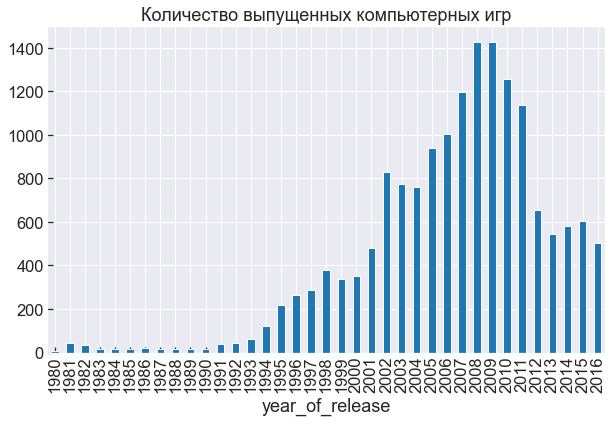

In [9]:
df.groupby('year_of_release')['name'].count().plot.bar()

plt.title('Количество выпущенных компьютерных игр')

plt.show()

- Игры, выпущенные раньше 1991 года, можно будет объеденить в одну группу. Их количество исчезающе мало по сравнению с периодом после. Наблюдается подозрительный спад количества выпускаемых игр начиная с 2009 года. Предположительно это связано с развитием индустрии мобильных игр.

_Продажи на разных платформах_

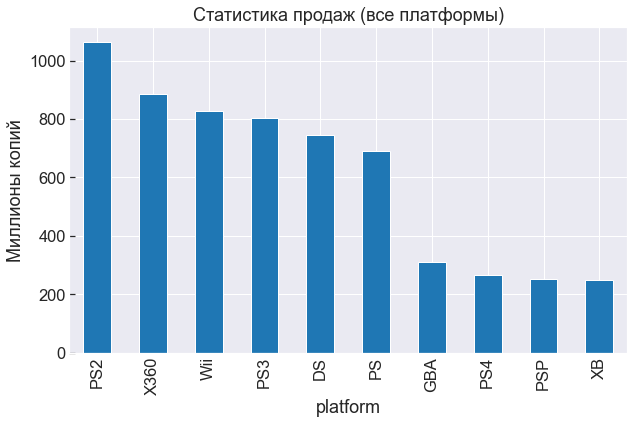

In [10]:
# Выберите платформы с наибольшими суммарными продажами
top_sales_platforms = df.groupby('platform')['total_sales'].sum().nlargest(10)

plt.ylabel('Миллионы копий')

plt.title('Статистика продаж (все платформы)')

top_sales_platforms.plot.bar()

plt.show()

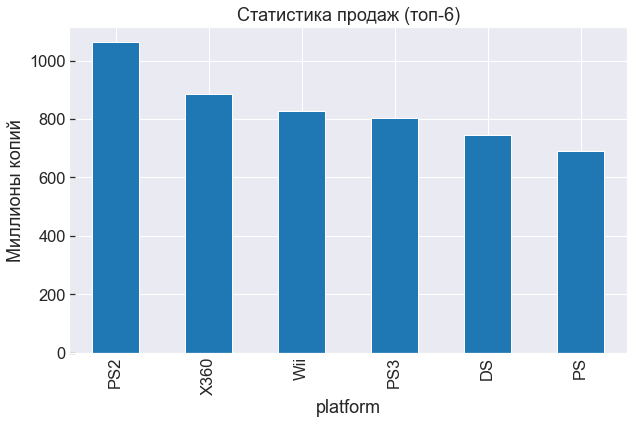

In [11]:
# Ограничусь шестью самыми крупными по прадажам
top_sales_platforms = df.groupby('platform')['total_sales'].sum().nlargest(6)

plt.ylabel('Миллионы копий')
plt.title('Статистика продаж (топ-6)')

top_sales_platforms.plot.bar()

plt.show()

In [12]:
top_names = list(top_sales_platforms.index)

# Добавляю PC для сравнения
top_names.append('PC')

print(top_names)

top_sales_df = df[df['platform'].isin(top_names)]

top_sales_df.shape

['PS2', 'X360', 'Wii', 'PS3', 'DS', 'PS', 'PC']


(10396, 12)

In [13]:
top_sales_groups = top_sales_df.groupby(['platform', 'year_of_release'])['total_sales'].agg(('sum'))

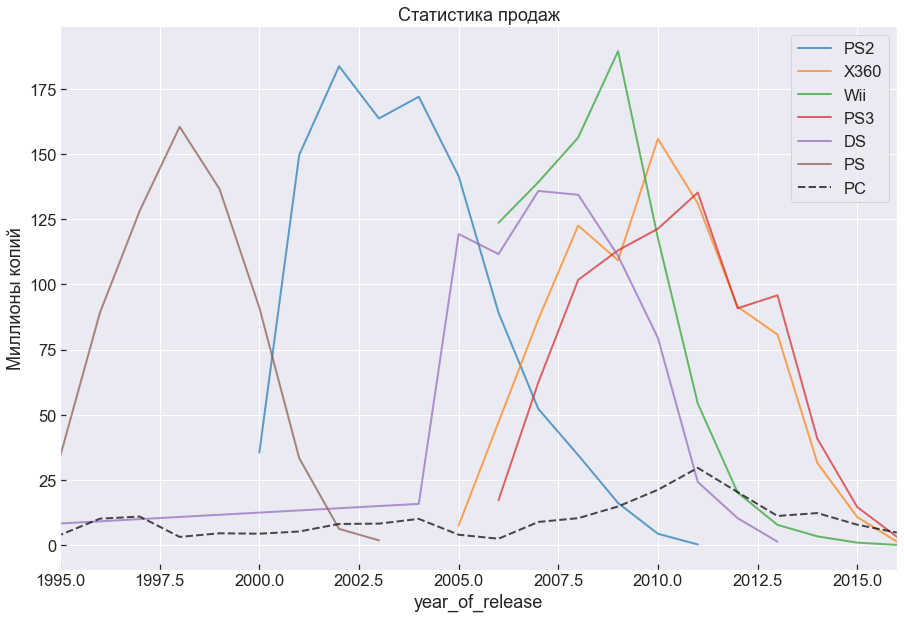

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

for platform_name in top_sales_platforms.index:

    stat_df = top_sales_groups.loc[[platform_name]].reset_index(level=0, drop=True)

    stat_df.plot(ax=ax, alpha=.7, lw=2, label=platform_name)

stat_df = top_sales_groups.loc[['PC']].reset_index(level=0, drop=True)
stat_df.plot(ax=ax, alpha=.7, lw=2, label='PC', color='k', ls='--')

plt.ylabel('Миллионы копий')
plt.title('Статистика продаж')

plt.xlim(1995, 2016)
plt.legend()
plt.show()

- Актуальный период, данные за который помогут построить прогноз на 2017 год: 2012 - 2016
> Обоснование: , поэтому данные по этому периоду я не буду принимать во внимание в дальнейшем. Тем не менее, данные даже за этот период согласуются с утверждением о том, что

- Характерный срок, за который возникают и исчезают платформы состовляет около семи лет. Кроме того, есть ощущение, что с течением времени платформы начинают устаревать быстрее (см. график ниже).

***

***

In [149]:
# Данные для формирования прогноза на 2017 год

limit_year = 2012

predict_df = df[df['year_of_release'] >= limit_year]

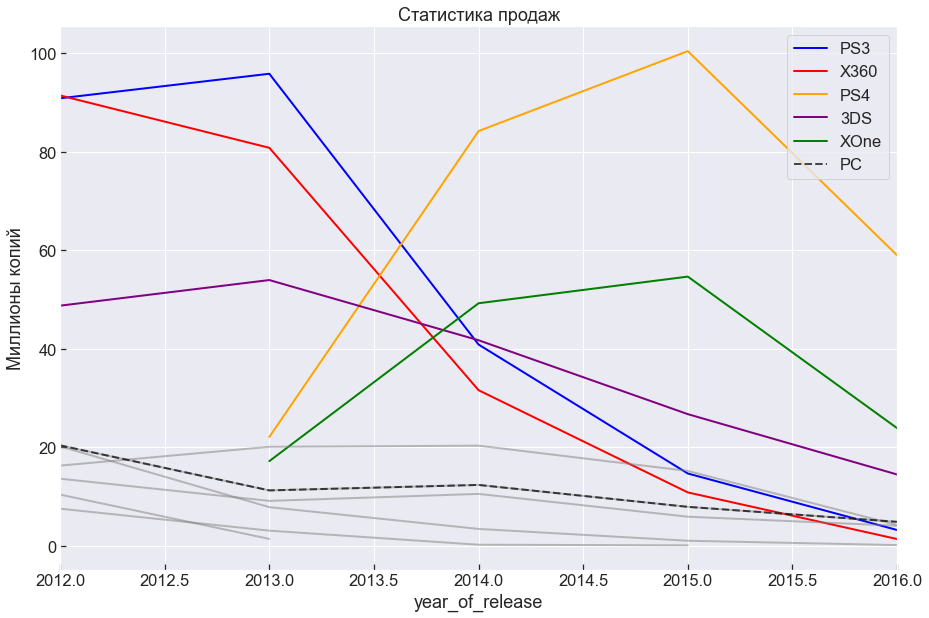

In [150]:
predict_stat_df = predict_df.groupby(['platform', 'year_of_release'])['total_sales'].agg(('sum'))

colors = ['blue', 'red', 'orange', 'purple', 'green', 'lime', 'yellow']

fig, ax = plt.subplots(figsize=(15, 10))

# Счетчик
i = 0

for platform_name in predict_df['platform'].unique():

    stat_df = predict_stat_df.loc[[platform_name]].reset_index(level=0, drop=True)
    stat_df = pd.DataFrame(stat_df)

    if stat_df['total_sales'].max() < 40:
        color='grey'
        platform_name=None
        alpha = .5
    else:
        color = colors[i]
        i+=1
        alpha = 1

    ax.plot(stat_df, lw=2, color=color, alpha=alpha, label=platform_name)
    ax.legend()


stat_df = predict_stat_df.loc[['PC']].reset_index(level=0, drop=True)
stat_df.plot(ax=ax, alpha=.7, lw=2, label='PC', color='k', ls='--')

ax.legend()

plt.ylabel('Миллионы копий')
plt.title('Статистика продаж')

plt.xlim(limit_year, 2016)
plt.legend()
plt.show()

- Для всех платформ наблюдается тенденция к уменьшению количества проданных копий
- При этом по количеству продаж лидируют PS4 и XOne
- Серыми линиями внизу показаны преимущественно портативные платформы (WiiU, DS и др.)
- Штриховой линией отмечены продажи игр на ПК

In [151]:
predict_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,17.09
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,14.86
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,12.25
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,13.82
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,11.37
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


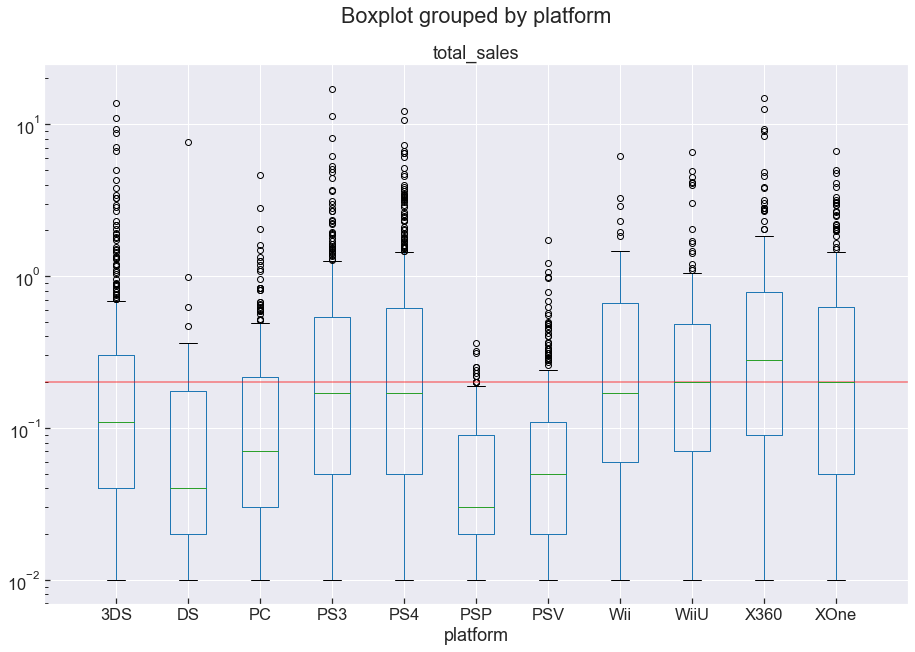

In [152]:
fig, ax = plt.subplots(figsize=(15, 10))

predict_df.boxplot('total_sales', by='platform', ax=ax)
ax.set_yscale('log')

ax.hlines(.2, 0, 13, color='red', alpha=.5)
ax.set_xlim(0, 12)

plt.show()

- По медианному количеству проданных копий различных игр лидируют платформы X360, XOne, PS3, PS4, Wii и WiiU